In [1]:
import numpy
%run ../../base-notebook.ipynb

2023-07-07 21:42:52 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt [746/746] -> "../../ext/contents.txt" [1]
2023-07-07 21:42:52 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py [8266/8266] -> "../../ext/ml_callback.py" [1]
2023-07-07 21:42:52 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_internal.py [3032/3032] -> "../../ext/ml_internal.py" [1]
2023-07-07 21:42:53 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_io.py [2664/2664] -> "../../ext/ml_io.py" [1]
2023-07-07 21:42:53 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_layer.py [9525/9525] -> "../../ext/ml_layer.py" [1]
2023-07-07 21:42:53 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_plot.py [25391/25391] -> "../../ext/ml_plot.py" [1]
2023-07-07 21:42:53 URL:https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_util.py [2085/2085] -> "../../ext/ml_util.py" [1]
2023-07-0

In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append("../../ext")

import ext.ml_callback as mlc
import ext.ml_io as mli
import ext.ml_layer as mll
import ext.ml_plot as mlp
import ext.ml_util as mlu
import ext.ml_data as mld
import ext.ml_view as mlv
import ext.ml_analyze as mla
import ext.ml_shell as mls

import tensorflow as tf
import pandas as pd

import opendatasets as od

import tensorflow_hub as hub

from keras import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, GlobalAveragePooling1D, Flatten, Activation, TextVectorization, Embedding, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.losses import binary_crossentropy

# NLP Fundamentals in TensorFlow

# Get a text dataset

The dataset we are going to be using is Kaggle's introduction to NLP dataset. These are text samples of Tweets labeled as disaster or not.

https://www.kaggle.com/competitions/nlp-getting-started

In [4]:
# Download the dogs and cats dataset
mli.download_file(source="https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip", filepath="./data/nlp_getting_started.zip")
mli.extract_zip(filepath="./data/nlp_getting_started.zip", folder="./data")

Download of https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip completed.


## Visualizing a text dataset

In [5]:
# Load test and training data.
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
mld.dataframe_describe(train_df)

Total number of rows: 7613


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,id,int64,7613,0,7613,5441.93,3137.12,-3969.41,14853.28,1.0,2734.0,5408.0,8146.0,10873.0
1,keyword,object,7552,61,221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,location,object,5080,2533,3341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,text,object,7613,0,7503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,target,int64,7613,0,2,0.43,0.50,-1.06,1.91,0.0,0.0,0.0,1.0,1.0


In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Check if dataset is balanced

Read more about inbalanced classification on:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [9]:
# How many examples of each class are there, a balanced set would be 50/50, in this case it is 58/42 which is balanced enough.
train_df_shuffled.target.value_counts()
# train_df_shuffled.groupby(by='target').count()

target
0    4342
1    3271
Name: count, dtype: int64

In [10]:
# How many total samples, this is a 70/30
len(train_df_shuffled), len(test_df)

(7613, 3263)

In [11]:
# Let's visualize some random training samples
import random
random_index = random.randint(0, len(train_df) - 5) # Create random indexes not higher then the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row;
    print(f"Target: {target}", "(real dissaster)" if target > 0 else "(not real disaster)")
    print(f"Text: \n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text: 
@CranBoonitz So going to make any bomb threats? @HereticOfEthics

---

Target: 0 (not real disaster)
Text: 
Rite now man a tlk widout nuh curfew long side Aka cum fi steal di show itz a rubbery di whole a dem fi knw... Sound it *music*

---

Target: 1 (real dissaster)
Text: 
Another entity forced to close in Montego Bay as a result of the collapsed sewer line #TVJNews

---

Target: 1 (real dissaster)
Text: 
Truth...
https://t.co/p5ZIcjUdXO
#News
#BBC
#CNN
#Islam
#Truth
#god
#ISIS
#terrorism
#Quran
#Lies http://t.co/kZhB8zX6YC

---

Target: 0 (not real disaster)
Text: 
13 reasons why we love women in the military   - lulgzimbestpicts http://t.co/uZ1yiZ7n6m http://t.co/IjwAr15H16

---



# Split data into training and validation sets.

In [12]:
train_sentences, val_sentences, train_labels, val_labels = mlu.split_train_test_data(train_df_shuffled['text'].to_numpy(),
                                                                                     train_df_shuffled['target'].to_numpy(),
                                                                                     test_size=.1,
                                                                                     train_size=.9,
                                                                                     random_state=42)

In [13]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [14]:
# Check first examples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Convert text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are few ways to this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create matrix of feature vectors for each token (the size of the feature vector can be defined and this embedding can be learned).

### Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

The processing of each example contains the following steps:

* Standardize each example (usually lowercasing + punctuation stripping)
* Split each example into substrings (usually words)
* Recombine substrings into tokens (usually ngrams)
* Index tokens (associate a unique int value with each token)
* Transform each example using this index, either into a vector of ints or a dense float vector.

In [16]:
# Use the default TextVectorization parameters

text_vectorizer = TextVectorization(
    max_tokens=None, # How many words in the vocabulary, it will automatically add a <OOV> token, OOV stands for Out Of Vocabulary, in get_vocabulary this results in [UNK]
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None, # Create groups of n-words
    output_mode="int", # How to map tokens to numbers
    output_sequence_length=None, # Fill with zeros to maintain consistent shape size
    pad_to_max_tokens=False, # Not applicable for output_mode = int, only for multi_hot, count and tf_idf
)

Metal device set to: Apple M1 Max


In [17]:
max_vocab_length = 10000 # Max number of words to have in our vocabulary
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # Max length our sequences will be (e.g. how many words of a tweet does a model see)

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int", # How to map tokens to numbers
    output_sequence_length=max_length, # Fill with zeros to maintain consistent shape size
)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

2023-07-14 22:44:02.479045: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it.
random_sentence = random.choice(train_sentences)
print(f"Original:\n{random_sentence}\n\nVectorized: {text_vectorizer([random_sentence])}")

Original:
Crazy storm hit and I'm trapped inside a Hobby Lobby AMA http://t.co/8qc8Bcxoko

Vectorized: [[858  84 244   7  32 448 622   3   1   1   1   1   0   0   0]]


In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # Get all of the unique words in the vocabulary
f"10 Most common words {words_in_vocab[:10]}", f"10 Least common words: {words_in_vocab[-5:]}", f"Number of words in vocabulary: {len(words_in_vocab)}"

("10 Most common words ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']",
 "10 Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']",
 'Number of words in vocabulary: 10000')

### Creating an Embedding using an Embedding Layer

To make our embedding we are going to use TensorFlows embedding layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:

* 'input_dim' = the size of our vocabulary
* 'output_dim' = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector of 100 long.
* 'input_length' = length of the sequences (also defined in the TextVectorization = 15)

In [22]:
embedding = Embedding(input_dim=max_vocab_length, # Set the input shape
                      output_dim=128, # Use a number that is divisble by 8
                      input_length=max_length # How long is each input sequence
                      )
embedding

In [23]:
# Get a random sentence from the the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence} \
      \n\rEmbedded version:")

# Embedd the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed


Original text: @olrules Welcome - Read a free chapter of my new book Encounters With Jesus. It's full of hope. http://t.co/6qX7arf4AG       
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04390116,  0.03146435, -0.00912938, ..., -0.04191096,
         -0.04780544, -0.02899618],
        [ 0.03286816, -0.04715992,  0.00945038, ..., -0.00145661,
          0.00806078, -0.03254845],
        [-0.00449502, -0.04556825,  0.00498804, ...,  0.0245238 ,
         -0.02053446,  0.00350249],
        ...,
        [-0.0471265 ,  0.03963828,  0.0021392 , ...,  0.00287252,
         -0.03308171, -0.04132705],
        [-0.04113631,  0.01086973, -0.00640494, ...,  0.02200084,
         -0.00885201,  0.04673872],
        [ 0.02936075, -0.01331292,  0.00856156, ...,  0.04433377,
         -0.03900796, -0.03341686]]], dtype=float32)>

In [24]:
# Check out a single tokens embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.04390116,  0.03146435, -0.00912938,  0.04610903,  0.04899014,
         0.04383754,  0.04281122, -0.01613664, -0.0310212 ,  0.00868977,
         0.01727385,  0.03863473,  0.00150621,  0.01559618,  0.01002342,
         0.04863727, -0.01130848,  0.00989664,  0.0438596 ,  0.0497105 ,
         0.0131689 , -0.01680869,  0.01751227,  0.04566261, -0.04670068,
        -0.01379221,  0.01490721, -0.00301351, -0.01525608,  0.00686681,
        -0.01325975, -0.00836561,  0.02852103, -0.04482416,  0.03719645,
         0.04896214,  0.04410844,  0.04674096, -0.00397165,  0.0109951 ,
         0.04091061, -0.04960125, -0.00054861, -0.02194555, -0.03935815,
         0.0006128 ,  0.02227295, -0.00238243, -0.0399981 , -0.01635004,
        -0.04857215, -0.01148343,  0.01195527, -0.00727613, -0.0144694 ,
         0.01118181,  0.04228793, -0.0203662 ,  0.01964309,  0.04809293,
         0.03558147, -0.01951787, -0.0479832 ,  0.04359618, -0.00170988,
  

## Modelling a text dataset (running a series of experiments)

Source:

* Model 0: Naive Bayes (baseline) Source: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed Forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D convolutional Neural Network
* Model 6: TensorFlow Hub pretrained feature extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with TensorFlow.

* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline

As with all machine learning experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

So to create our baseline will use SKLearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

Note: It's common practice to use non-DL (deep learning) algorithms as a baseline because of their speed and then later use DL to see if you can improve upon them.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words to numbers using TF-IDF
    ("clf", MultinomialNB()) # Model the text  (clf = classifier)
])

# Fit the pipeline to the training data.
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of 79.27%


Results are not bad, the training data consists of 4342 vs 3271 for non-disaster and disaster which is about 42% disaster samples and 58% non-disaster samples. If the model was guessing the result would be around 55%. So the baseline is doing a fair bit better then guessing.

In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our models predictions every time, however, this will be cumbersome and could easily be fixed with a function

Let's create one to compare our model's predictions with the truth labels using the folowing metrics:

* Accuracy
* Precission (high precision leads to less false positives)
* Recall (High recall leads to less false negatives)
* F1-Score (combination of precission / recall)

For a deep overview of many different evaluation methods, see the SKLearn documentation:

https://scikit-learn.org/stable/modules/model_evaluation.html

In [28]:
baseline_results = mlp.table_quality_metrics(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

The model has a higher precision wich would lead to less false-positives.

# Model 1: Feed forward neural network (Dense model)

In [29]:
# Build model with the functional API
inputs = Input(shape=(1,), dtype=tf.string) # Inputs are 1-dimensional
x = text_vectorizer(inputs) # Turn the input text to numbers
x = embedding(x) # Create an embedding of the numberized inputs
x = GlobalAveragePooling1D()(x) # Condense the feature vector for each token to one vector
outputs = Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function

model_1 = Model(inputs, outputs, name="model_1_dense")

In [30]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [31]:
# Compile the model
model_1.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

In [32]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[mlc.create_tensorboard_callback(experiment_name="model_1_dense", dir_name="./model_logs")]
                              )

Saving TensorBoard log files to: ./model_logs/model_1_dense/20230714-224421
Epoch 1/5


InvalidArgumentError: Cannot assign a device for operation model_1_dense/embedding/embedding_lookup: Could not satisfy explicit device specification '' because the node {{colocation_node model_1_dense/embedding/embedding_lookup}} was colocated with a group of nodes that required incompatible device '/job:localhost/replica:0/task:0/device:GPU:0'. All available devices [/job:localhost/replica:0/task:0/device:CPU:0, /job:localhost/replica:0/task:0/device:GPU:0]. 
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=2 requested_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' assigned_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' resource_device_name_='/job:localhost/replica:0/task:0/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
AssignSubVariableOp: GPU CPU 
RealDiv: GPU CPU 
Sqrt: GPU CPU 
AssignVariableOp: GPU CPU 
UnsortedSegmentSum: GPU CPU 
Identity: GPU CPU 
StridedSlice: CPU 
Const: GPU CPU 
NoOp: GPU CPU 
Mul: GPU CPU 
Shape: GPU CPU 
_Arg: GPU CPU 
ResourceScatterAdd: GPU CPU 
Unique: GPU CPU 
ReadVariableOp: GPU CPU 
AddV2: GPU CPU 
ResourceGather: GPU CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  model_1_dense_embedding_embedding_lookup_1404 (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_readvariableop_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  adam_adam_update_readvariableop_2_resource (_Arg)  framework assigned device=/job:localhost/replica:0/task:0/device:GPU:0
  model_1_dense/embedding/embedding_lookup (ResourceGather) 
  model_1_dense/embedding/embedding_lookup/Identity (Identity) 
  Adam/Adam/update/Unique (Unique) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/Shape (Shape) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/strided_slice/stack (Const) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/strided_slice/stack_1 (Const) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/strided_slice/stack_2 (Const) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/strided_slice (StridedSlice) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/UnsortedSegmentSum (UnsortedSegmentSum) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/mul (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/ReadVariableOp (ReadVariableOp) 
  Adam/Adam/update/mul_1 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/AssignVariableOp (AssignVariableOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/ResourceScatterAdd (ResourceScatterAdd) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/ReadVariableOp_1 (ReadVariableOp) 
  Adam/Adam/update/mul_2 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/mul_3 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/ReadVariableOp_2 (ReadVariableOp) 
  Adam/Adam/update/mul_4 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/AssignVariableOp_1 (AssignVariableOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/ResourceScatterAdd_1 (ResourceScatterAdd) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/ReadVariableOp_3 (ReadVariableOp) 
  Adam/Adam/update/Sqrt (Sqrt) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/mul_5 (Mul) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/add (AddV2) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/truediv (RealDiv) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/AssignSubVariableOp (AssignSubVariableOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/group_deps/NoOp (NoOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/group_deps/NoOp_1 (NoOp) /job:localhost/replica:0/task:0/device:GPU:0
  Adam/Adam/update/group_deps (NoOp) /job:localhost/replica:0/task:0/device:GPU:0

	 [[{{node model_1_dense/embedding/embedding_lookup}}]] [Op:__inference_train_function_1676]

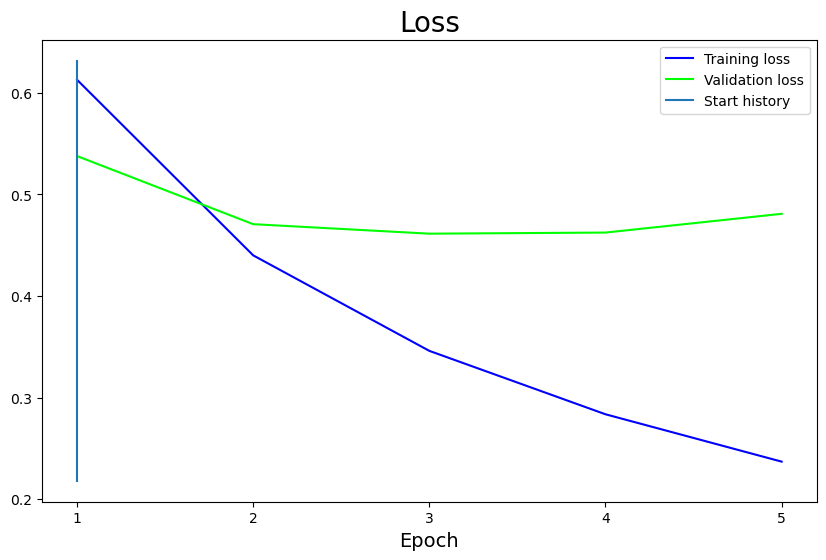

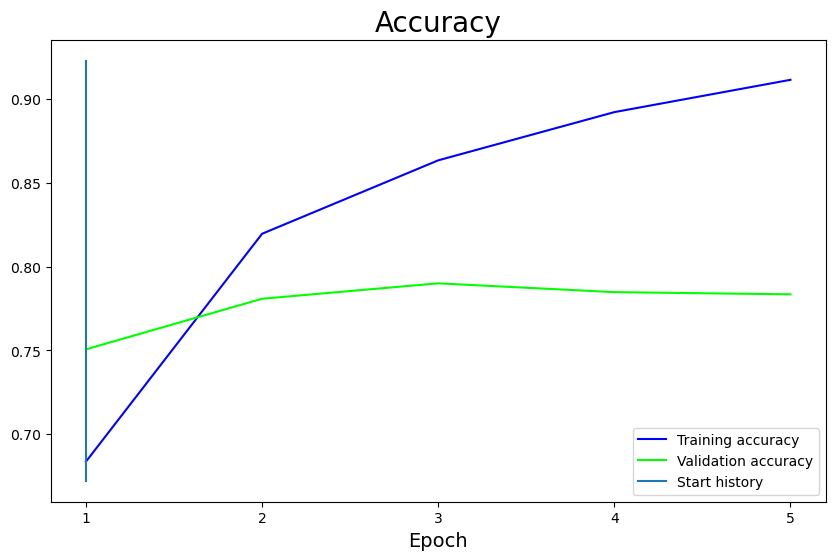

In [32]:
mlp.plot_history(model_1_history)

In [33]:
# Evaluate the model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 9ms/step - loss: 0.4809 - accuracy: 0.7835


[0.4809361398220062, 0.7834645509719849]

In [34]:
# Make some predictions
model_1_pred_propbs = model_1.predict(x=val_sentences)
model_1_pred_propbs

24/24 [==============================] - 0s 4ms/step


array([[3.85779113e-01],
       [7.37775505e-01],
       [9.97845411e-01],
       [1.29810899e-01],
       [1.06930427e-01],
       [9.41055655e-01],
       [8.99662614e-01],
       [9.91822660e-01],
       [9.65827942e-01],
       [2.78519571e-01],
       [1.10484369e-01],
       [6.73792779e-01],
       [4.98846732e-02],
       [2.13963270e-01],
       [4.32847161e-03],
       [1.25860527e-01],
       [2.25827489e-02],
       [8.92205238e-02],
       [2.35289678e-01],
       [5.16482711e-01],
       [9.06633198e-01],
       [3.59350368e-02],
       [3.99055094e-01],
       [8.11952725e-02],
       [9.56498027e-01],
       [9.98895109e-01],
       [3.80460098e-02],
       [8.45771283e-02],
       [2.43557058e-02],
       [1.71537712e-01],
       [5.76249719e-01],
       [2.44466081e-01],
       [4.11440790e-01],
       [1.56514958e-01],
       [4.72189665e-01],
       [6.99158385e-02],
       [9.94458795e-01],
       [1.53233543e-01],
       [3.24829705e-02],
       [9.98300731e-01],


In [35]:
model_1_pred_propbs.shape

(762, 1)

In [36]:
# Convert model prediction probabilities to label format
# First squeeze the results so we go from a two dimensional shape (762, 1) to a one dimensional shape (762,)
# Then round the results
model_1_preds = tf.round(tf.squeeze(model_1_pred_propbs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [37]:
# Calculate our model one results
# TODO: CREATE BETTER RESULT FORMAT (Dataframe?, NP array?)
model_1_results = mlp.table_quality_metrics(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 0.7884290282979772,
 'recall': 0.7834645669291339,
 'f1': 0.7803444000779524}

In [38]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [39]:
# Comapre the results from both models (order does not have to be the same)
# TODO: CREATE FUNCTION
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Visualizing learned embeddings

In [40]:
# Get the vocabulary from the text verctorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [41]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [42]:
# Get the weight matrix of the embedding layer
# (these are the numerical representations of each token in our training data)
embed_weights = model_1.get_layer(name="embedding").get_weights()[0]
# Is also the same
# embed_weights = embedding.weights

Now we've got the embeddings matrix our model has learned to represent our tokens, let's see how we can visualize it. To do so, TensorFlow has a handy tool called Projector.

https://projector.tensorflow.org

And TensorFlow also has an incredible guide on word embeddings themselfs.

In [43]:
# So for each token (total of 10.000 tokens in our vocabulary) we have a 128 length vector
embed_weights.shape

(10000, 128)

In [44]:
# TODO: Implement as function
import io

out_v = io.open('./embedding/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('./embedding/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [45]:
# TODO: Implement as function?

# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Recurrent neural networks

RNN's are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

If you want an overview of the internals of RNN, see the following:

- MIT: Sequence modelling lecture: https://youtu.be/ySEx_Bqxvvo
- LSTM Chris Olah: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# Model 2: LSTM

LSTM = Long Short Term Memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:


```
Input (TEXT) -> Tokenize -> Embedding -> Layers (RNN's/Dense) -> Output (label probability)
```

In [46]:
# Create an LSTM model
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = LSTM(units=64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to return_sequences=True
print(x.shape)
x = LSTM(units=64)(x)
print(x.shape)
x = Dense(units=64, activation="relu")(x)
outputs = Dense(units=1, activation="sigmoid")(x)

model_2 = Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)


The input arguments for the LSTM are (batch, timesteps, feature), so in our case this is (batch=None, timesteps=15, feature=64)

In [47]:
# Create an LSTM model
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = LSTM(units=64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to return_sequences=True
# print(x.shape)
x = LSTM(units=64)(x)
# print(x.shape)
# x = Dense(units=64, activation="relu")(x)
outputs = Dense(units=1, activation="sigmoid")(x)

model_2 = Model(inputs, outputs, name="model_2_LSTM")

In [48]:
# Get a summary.
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [49]:
# Compile the model
model_2.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [50]:
model_2_history = model_2.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=mlc.create_tensorboard_callback("model_2_lstm", dir_name="./model_logs")
)

Saving TensorBoard log files to: ./model_logs/model_2_lstm/20230712-154802
Epoch 1/5
215/215 [==============================] - 7s 26ms/step - loss: 0.2212 - accuracy: 0.9240 - val_loss: 0.6030 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1577 - accuracy: 0.9404 - val_loss: 0.5930 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1266 - accuracy: 0.9515 - val_loss: 0.7307 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1071 - accuracy: 0.9590 - val_loss: 0.7522 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0900 - accuracy: 0.9645 - val_loss: 0.9932 - val_accuracy: 0.7769


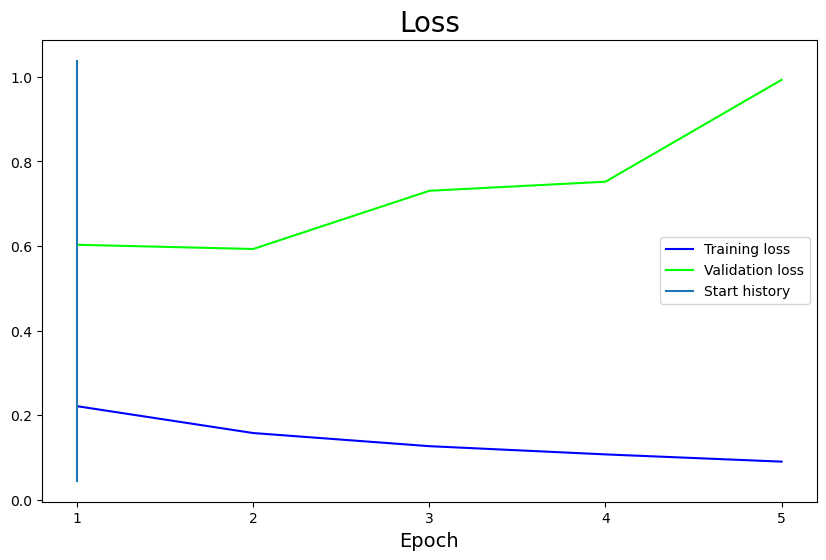

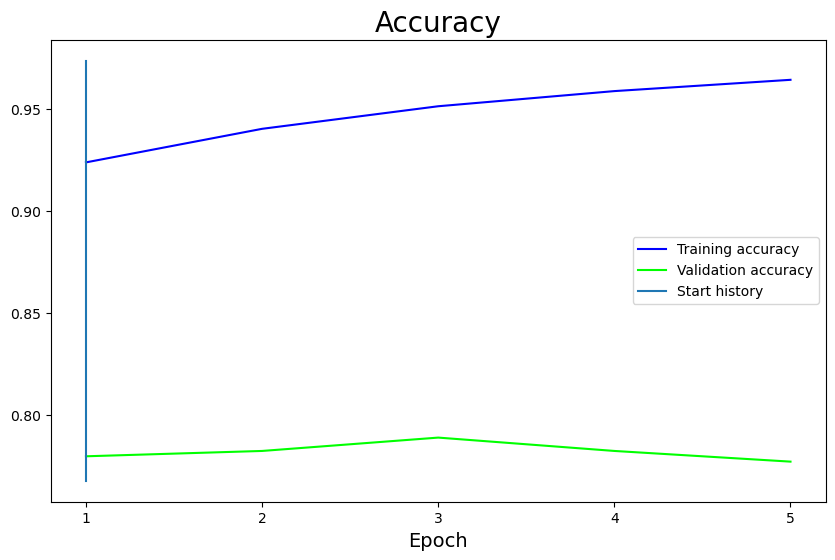

In [51]:
mlp.plot_history(model_2_history)

In [52]:
model_2_pred_props = model_2.predict(val_sentences)
model_2_pred_props[:10]

24/24 [==============================] - 0s 6ms/step


array([[2.9608195e-03],
       [6.0659558e-01],
       [9.9978870e-01],
       [1.2206977e-02],
       [5.9629558e-04],
       [9.9909687e-01],
       [9.7015518e-01],
       [9.9984205e-01],
       [9.9975246e-01],
       [3.8223544e-01]], dtype=float32)

In [53]:
# Convert model 2 predictions to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_props))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [54]:
# Check the results from model_2
model_2_results = mlp.table_quality_metrics(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7789562668302826,
 'recall': 0.7769028871391076,
 'f1': 0.7747522807746444}

In [55]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model 3: GRU

Another popular effective RNN component is the GRU - Gated Recurrent Unit.

The GRU cell (GRU Layer) has similar features to an LSTM cell but has less parameters.

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [56]:
# Build an RNN using the GRU cell
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(units=64, return_sequences=False)(x)
outputs = Dense(1, activation="sigmoid")(x)
model_3 = Model(inputs, outputs, name="model_3_gru")

In [57]:
model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [58]:
model_3.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [59]:
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[mlc.create_tensorboard_callback("model_3_gru", dir_name="./model_logs")])

Saving TensorBoard log files to: ./model_logs/model_3_gru/20230712-154828
Epoch 1/5
215/215 [==============================] - 7s 26ms/step - loss: 0.1523 - accuracy: 0.9438 - val_loss: 0.7504 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0834 - accuracy: 0.9702 - val_loss: 0.8027 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0715 - accuracy: 0.9718 - val_loss: 0.9143 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0611 - accuracy: 0.9771 - val_loss: 1.0322 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0534 - accuracy: 0.9778 - val_loss: 1.3208 - val_accuracy: 0.7743


In [60]:
# Make some predictions
model_3_pred_props = model_3.predict(x=val_sentences)
model_3_pred_props[:10]

24/24 [==============================] - 0s 6ms/step


array([[4.0016777e-04],
       [8.4066832e-01],
       [9.9989080e-01],
       [1.8795280e-01],
       [9.1314447e-05],
       [9.9991202e-01],
       [9.9331033e-01],
       [9.9996924e-01],
       [9.9993372e-01],
       [9.9970275e-01]], dtype=float32)

In [61]:
# Convert model_3_pred_props, first round the values then squeeze to remove dimensions.
model_3_preds = tf.squeeze(tf.round(model_3_pred_props))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
# Calculate model 3 results
model_3_results = mlp.table_quality_metrics(val_labels, model_3_preds)
model_3_results

{'accuracy': 77.42782152230971,
 'precision': 0.7759894665484696,
 'recall': 0.7742782152230971,
 'f1': 0.7722311836526509}

In [63]:
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7789562668302826,
 'recall': 0.7769028871391076,
 'f1': 0.7747522807746444}

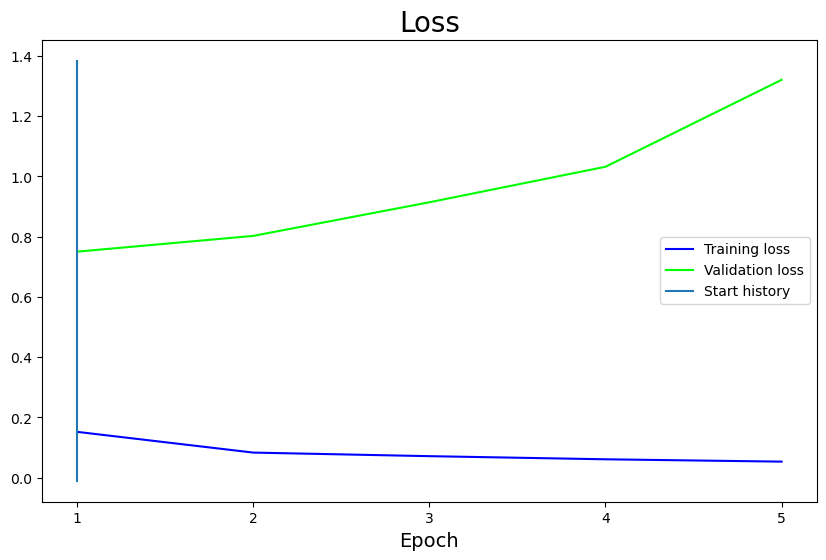

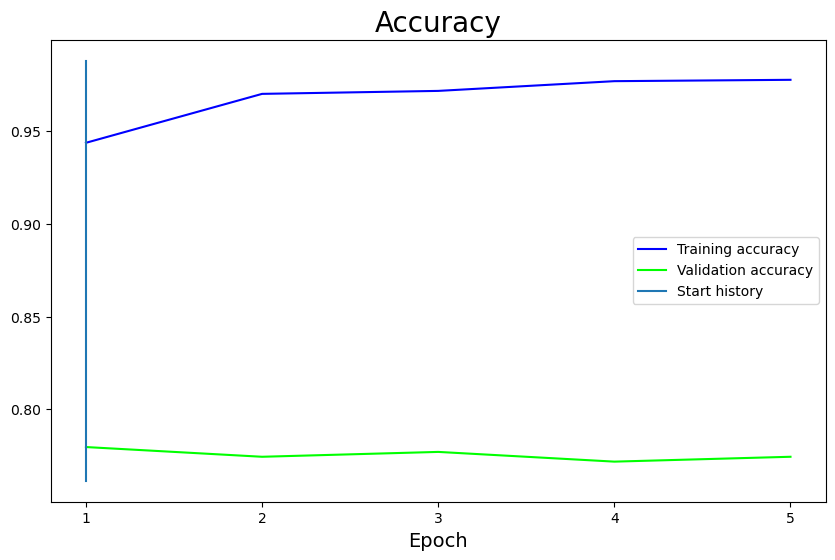

In [64]:
mlp.plot_history(model_3_history)

# Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however, bidirectionals go from right to left as well as left to right.

In [65]:
# Build a bidirectional RNN in TensorFlow

inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(layer=LSTM(units=64, return_sequences=False))(x)
# x = Bidirectional(layer=GRU(units=64))(x)
outputs = Dense(1, activation="sigmoid")(x)

model_4 = Model(inputs, outputs, name="model_4_bidirectional")

In [66]:
# Get a summary

model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [67]:
# Compile the model
model_4.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [68]:
model_4_history = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[mlc.create_tensorboard_callback("model_3_bidirectional", dir_name="./model_logs")])

Saving TensorBoard log files to: ./model_logs/model_3_bidirectional/20230712-154850
Epoch 1/5
215/215 [==============================] - 8s 32ms/step - loss: 0.1068 - accuracy: 0.9696 - val_loss: 0.9050 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0528 - accuracy: 0.9780 - val_loss: 1.1159 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0490 - accuracy: 0.9780 - val_loss: 1.3216 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0453 - accuracy: 0.9800 - val_loss: 1.2146 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0393 - accuracy: 0.9816 - val_loss: 1.3683 - val_accuracy: 0.7717


In [69]:
# Make predictions abnd calculate results of our bidirectional model.
model_4_pred_props = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_props))
model_4_results = mlp.table_quality_metrics(val_labels, model_4_preds)
model_4_results

24/24 [==============================] - 1s 9ms/step


{'accuracy': 77.16535433070865,
 'precision': 0.7741380916586217,
 'recall': 0.7716535433070866,
 'f1': 0.7691811868378113}

# Model 5: Conv1D

We've used CNN's for images are typically 2D (HxW), however our text data is 1D.

Previously we have used Conv2D for our image data, but now we will use Conv1D.
The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layers (Conv1D + Pooling) -> Outputs (Dense layer)
```

For different explanations of parameter values:

CNN-Explainer: https://poloclub.github.io/cnn-explainer/
Same and Valid: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [70]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_text = embedding(text_vectorizer(['this is a test sentence'])) # Turn target sequence into an embedding
conv_1d = Conv1D(filters=64,
                 kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                 strides=1,
                 activation="relu",
                 padding="valid") # valid = output is smaller due to kernel_size / strides, change to same to pad values before / after the sequence.
conv_1d_output = conv_1d(embedding_text) # pass test embedding through conv_1d layer
max_pool = GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_text.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [71]:
# embedding_text

In [72]:
# conv_1d_output

In [73]:
# max_pool_output

In [74]:
# Create 1-dimensional convolutional layer to model sequences

inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(filters=64,
           kernel_size=5, # 5 words at a time.
           strides=1,
           activation="relu",
           padding="valid")(x)
# x = Flatten()(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(units=1, activation="sigmoid")(x)

model_5 = Model(inputs, outputs, name="model_4_conv1d")

In [75]:
model_5.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)              

In [76]:
model_5.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [77]:
model_5_history = model_5.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[mlc.create_tensorboard_callback(experiment_name="model_5_conv1d", dir_name="./model_logs")])

Saving TensorBoard log files to: ./model_logs/model_5_conv1d/20230712-154919
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.1233 - accuracy: 0.9574 - val_loss: 0.9169 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0738 - accuracy: 0.9733 - val_loss: 1.1104 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0597 - accuracy: 0.9768 - val_loss: 1.2118 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0557 - accuracy: 0.9766 - val_loss: 1.1928 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0519 - accuracy: 0.9783 - val_loss: 1.2117 - val_accuracy: 0.7585


In [78]:
model_5_pred_props = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_props))
model_5_results = mlp.table_quality_metrics(val_labels, model_5_preds)
model_5_results

24/24 [==============================] - 0s 4ms/step


{'accuracy': 75.8530183727034,
 'precision': 0.7582318952901055,
 'recall': 0.7585301837270341,
 'f1': 0.757619206049948}

# Model 6: TensorFlow Hub Pretrained Sentence Encode

Now we've build a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow's Hub's Universal Sentence Encoder

https://huggingface.co/docs/transformers/index
https://tfhub.dev/google/universal-sentence-encoder/4
https://arxiv.org/abs/1803.11175

In [79]:
embed = hub.load(handle="https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, "When you call the universal sentence encoder on a sentence it turns it into numbers"])
print(embed_samples)

tf.Tensor(
[[-0.01157026  0.0248591   0.02878049 ... -0.00186124  0.02315822
  -0.01485022]
 [ 0.03596691 -0.08579467 -0.01152743 ... -0.03414334  0.02816024
  -0.00878946]], shape=(2, 512), dtype=float32)


In [80]:
# Create Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[], # Since the input is defined as english text of variable length the layer in itself will make sure it fits
                                        dtype=tf.string,
                                        trainable=False, # we are doing feature extraction so we do not want to train this layer
                                        name='USE'
                                      )

In [81]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_6.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[mlc.create_tensorboard_callback("model_6_use", dir_name='./model_logs')])

Saving TensorBoard log files to: ./model_logs/model_6_use/20230712-154940
Epoch 1/5
215/215 [==============================] - 20s 88ms/step - loss: 0.5038 - accuracy: 0.7886 - val_loss: 0.4479 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 15s 70ms/step - loss: 0.4148 - accuracy: 0.8142 - val_loss: 0.4428 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 15s 70ms/step - loss: 0.4012 - accuracy: 0.8219 - val_loss: 0.4335 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 15s 70ms/step - loss: 0.3927 - accuracy: 0.8273 - val_loss: 0.4322 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 14s 66ms/step - loss: 0.3869 - accuracy: 0.8291 - val_loss: 0.4275 - val_accuracy: 0.8123


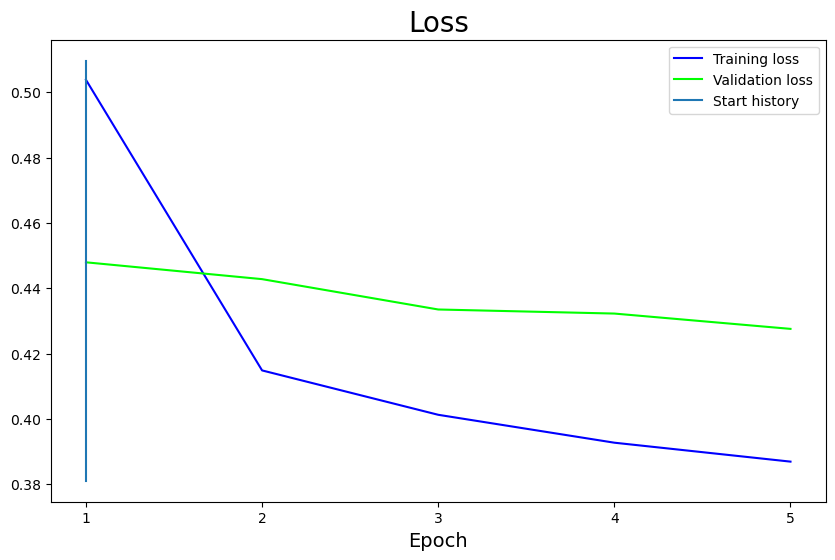

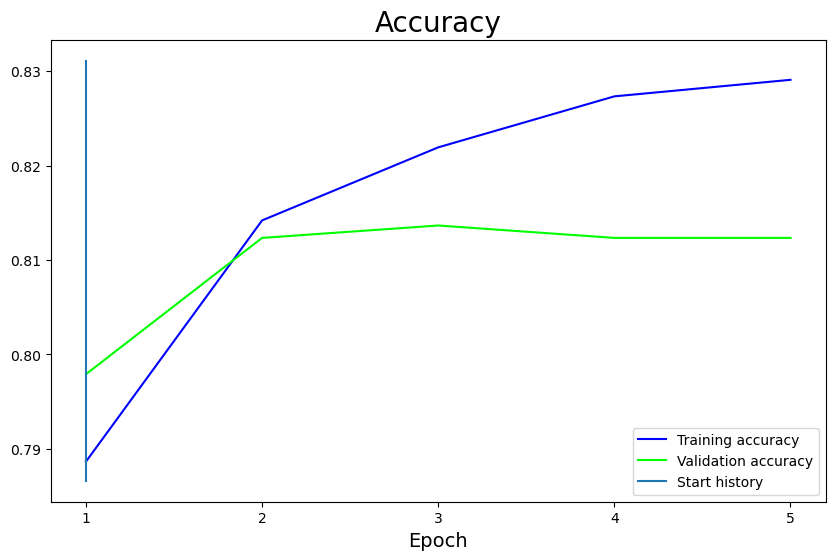

In [83]:
mlp.plot_history(model_6_history)

In [84]:
# Make predictions with the USE TF Hub Model
model_6_pred_props = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_props))
model_6_results = mlp.table_quality_metrics(val_labels, model_6_preds)
model_6_results

24/24 [==============================] - 4s 166ms/step


{'accuracy': 81.23359580052494,
 'precision': 0.8123900124632475,
 'recall': 0.8123359580052494,
 'f1': 0.8117376729557804}

In [85]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer Learning really helps when you don't have a large dataset, to see how our model performs on a smaller dataset, let's replicate model_6 except we'll train it on 10% of the data.

In [86]:
## Model 7: TF Hub Pretrained USE but with 10% of training data
# Note: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% of the data). DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAING SET (OR VICE VERSA)
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text']
# train_labels_10_percent = train_10_percent['target']
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [87]:
train_10_percent_split = int(.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent), train_sentences_10_percent[:10], train_labels_10_percent[:10]

(685,
 685,
 array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object)

In [88]:
# Check the number of targets in our 10 percent dataset
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
Name: count, dtype: int64

In [89]:
# Check the number of each label in the updated training data subset.
train_df_shuffled['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

To recreate a model the same as a previous model you've crfeated you can use the 'tf.keras.models.clone_model()' method.

In [90]:
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_7.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

In [91]:
# Fit the model using 10% of the training data.
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[mlc.create_tensorboard_callback(experiment_name='model_7_use_10_percent', dir_name='./model_logs')])

Saving TensorBoard log files to: ./model_logs/model_7_use_10_percent/20230712-155105
Epoch 1/5
22/22 [==============================] - 10s 431ms/step - loss: 0.6629 - accuracy: 0.6686 - val_loss: 0.6455 - val_accuracy: 0.7192
Epoch 2/5
22/22 [==============================] - 5s 219ms/step - loss: 0.5946 - accuracy: 0.7927 - val_loss: 0.5908 - val_accuracy: 0.7533
Epoch 3/5
22/22 [==============================] - 4s 197ms/step - loss: 0.5212 - accuracy: 0.8117 - val_loss: 0.5374 - val_accuracy: 0.7861
Epoch 4/5
22/22 [==============================] - 4s 180ms/step - loss: 0.4605 - accuracy: 0.8277 - val_loss: 0.5043 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 4s 170ms/step - loss: 0.4208 - accuracy: 0.8336 - val_loss: 0.4899 - val_accuracy: 0.7690


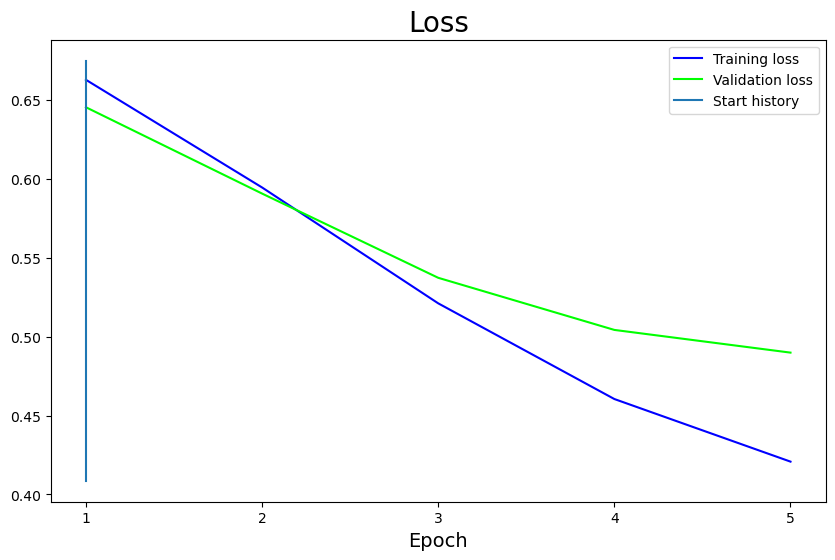

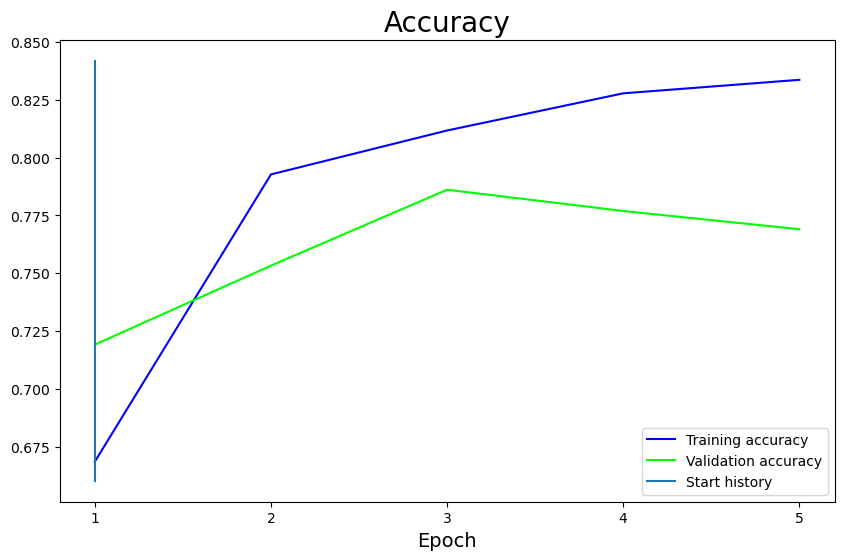

In [92]:
mlp.plot_history(model_7_history)

In [93]:
# Make some predictions
model_7_pred_props = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_props))
model_7_results = mlp.table_quality_metrics(val_labels, model_7_preds)
model_7_results

24/24 [==============================] - 5s 187ms/step


{'accuracy': 76.9028871391076,
 'precision': 0.769557843731072,
 'recall': 0.7690288713910761,
 'f1': 0.7675415573053368}

In [94]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Note: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% of the data). DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAING SET (OR VICE VERSA)

In [95]:
mls.start_tensorboard(dir_name='./model_logs')

http://localhost:6006


In [96]:
mls.stop_tensorboard()

# Comparing the performance of each of our models

In [97]:
# Combine model results into a dataframe
# TODO: Turn into function for mlp
all_model_results = pd.DataFrame(
    {
        "0_baseline" : baseline_results,
        "1_simple_dense": model_1_results,
        "2_lstm": model_2_results,
        "3_gru": model_3_results,
        "4_bidirectional": model_4_results,
        "5_conv1d": model_5_results,
        "6_tf_hub_100": model_6_results,
        "7_tf_hub_10": model_7_results
    }
)

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.788429,0.783465,0.780344
2_lstm,77.690289,0.778956,0.776903,0.774752
3_gru,77.427822,0.775989,0.774278,0.772231
4_bidirectional,77.165354,0.774138,0.771654,0.769181
5_conv1d,75.853018,0.758232,0.758530,0.757619
6_tf_hub_100,81.233596,0.812390,0.812336,0.811738
7_tf_hub_10,76.902887,0.769558,0.769029,0.767542


In [98]:
# Reduce accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

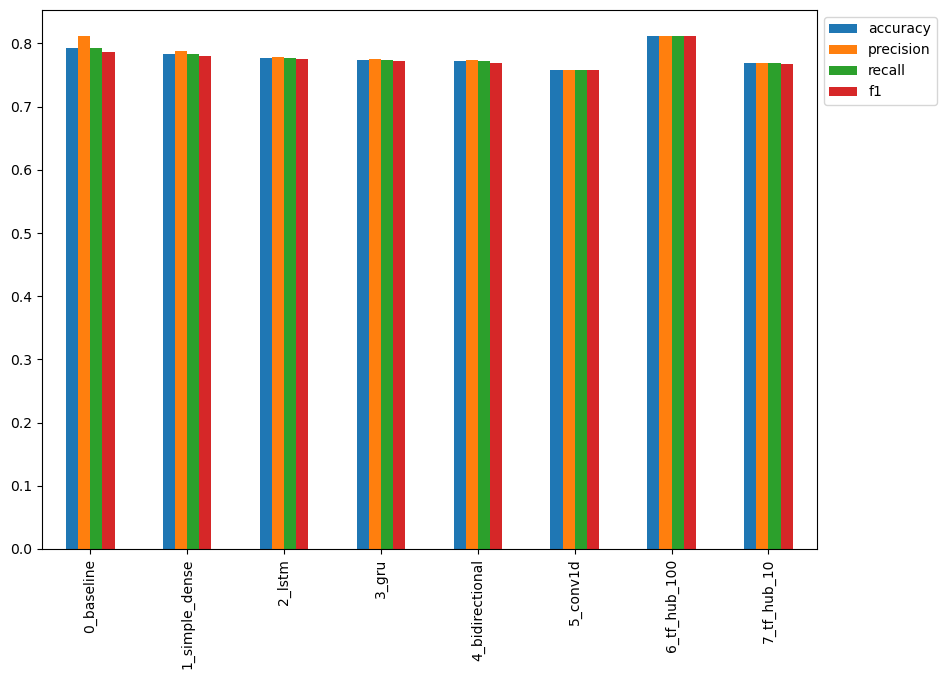

In [99]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

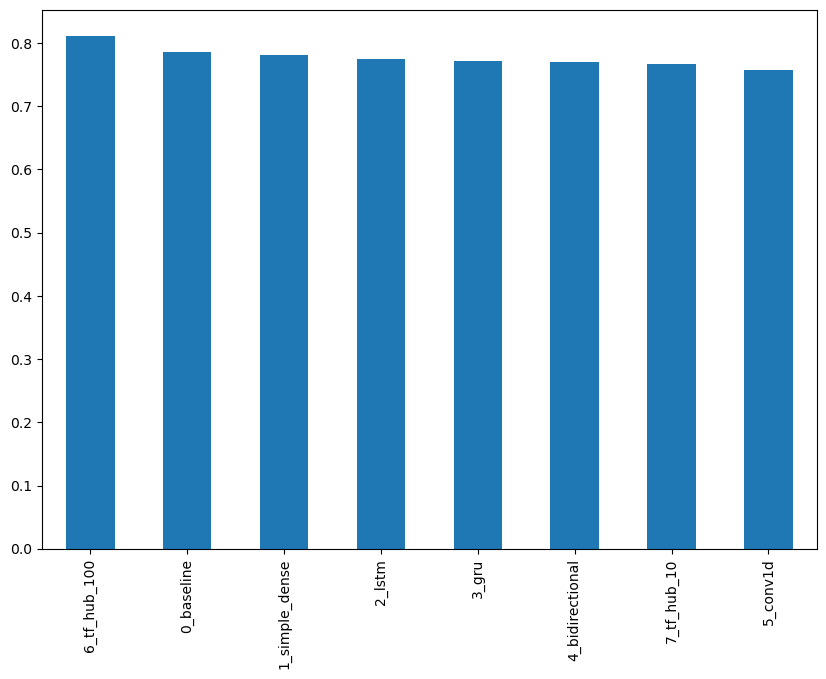

In [100]:
# Sort model results by f1-score
all_model_results.sort_values(by='f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

In [101]:
mls.start_tensorboard(dir_name='./model_logs')

http://localhost:6006


In [102]:
mls.stop_tensorboard()

TensorBoard caught SIGTERM; exiting...


# Saving and loading a trained model

There are two main formats in tensorflow:

1. The HDF5 format
2. The 'SavedModel' format (this is the default when using TensorFlow)

In [106]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save(filepath="./models/model_6.h5")

In [107]:
# Load model with custom hub-layer, this is required with the HDF5 format.
loaded_model_6 = mll.load_model(filepath="./models/model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [108]:
# Evaluate the model
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 6s 193ms/step - loss: 0.4275 - accuracy: 0.8123


[0.42754626274108887, 0.8123359680175781]

In [109]:
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8123900124632475,
 'recall': 0.8123359580052494,
 'f1': 0.8117376729557804}

In [110]:
# And now let's save to the Save Model format.
mll.save_model(model_6, filepath="./models/model_6.tf", save_format="tf")

INFO:tensorflow:Assets written to: ./models/model_6.tf/assets


INFO:tensorflow:Assets written to: ./models/model_6.tf/assets


In [111]:
# Load model with custom hub-layer, this is required with the HDF5 format.
loaded_model_6 = mll.load_model(filepath="./models/model_6.tf",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [112]:
# Evaluate the model
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 5s 187ms/step - loss: 0.4275 - accuracy: 0.8123


[0.42754626274108887, 0.8123359680175781]

# Find the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong.
* And of these wrong examples which ones is it getting *most* wrong, those will prediction probability closest to the oposite class).

For example if a sample should have a label of 0, but our model prediction probability of 0.999 (really close to 1) and vice versa.

This is called Model Driven Data Exploration, using the validation data and prediction probabilities and labels to find the most wrong awnsers and see if the data is wrongly labeled or if the data is just not suitable for the required end-result or if we might have errors in our model.


In [136]:
# Download pretrained model from Google Storage
mli.download_file(source='https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip', filepath='./data/08_model_6_USE_feature_extractor.zip')
mli.extract_zip(file='./data/08_model_6_USE_feature_extractor.zip', folder='./data')

In [137]:
model_6_pretrained = mll.load_model(filepath='./data/08_model_6_USE_feature_extractor')

In [179]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))

24/24 [==============================] - 2s 62ms/step


In [143]:
# TODO: Function
val_df = pd.DataFrame(
    {
        "text": val_sentences,
        "y_true": val_labels,
        "y_pred": model_6_pretrained_preds,
        "y_prob": tf.squeeze(model_6_pretrained_pred_probs)
    })
val_df.head()

,text,y_true,y_pred,y_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [148]:
most_wrong = val_df[val_df['y_true'] != val_df['y_pred']].sort_values(by='y_prob', ascending=False)
most_wrong[:10] # False Positives

,text,y_true,y_pred,y_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [149]:
most_wrong[-10:] # False Negatives

,text,y_true,y_pred,y_prob
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
221,going to redo my nails and watch behind the sc...,1,0.0,0.054597
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [150]:
# Check the false positives (model predicted 1 but should have been 0)
for row in most_wrong[:10].itertuples():
    _, text, y_true, y_pred, y_prob = row
    print(f"Target: {y_true}, Pred: {y_pred}, Prob: {y_prob}")
    print(f"Text: \n{text}\n")
    print("---")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text: 
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---
Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text: 
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---
Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text: 
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---
Target: 0, Pred: 1.0, Prob: 0.8354544639587402
Text: 
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---
Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text: 
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

---
Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text: 
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---
Targ

In [151]:
# Check the false positives (model predicted 1 but should have been 0)
for row in most_wrong[-10:].itertuples():
    _, text, y_true, y_pred, y_prob = row
    print(f"Target: {y_true}, Pred: {y_pred}, Prob: {y_prob}")
    print(f"Text: \n{text}\n")
    print("---")

Target: 1, Pred: 0.0, Prob: 0.06730347126722336
Text: 
@DavidVonderhaar At least you were sincere ??

---
Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text: 
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---
Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text: 
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---
Target: 1, Pred: 0.0, Prob: 0.054596975445747375
Text: 
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

---
Target: 1, Pred: 0.0, Prob: 0.04963728412985802
Text: 
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---
Target: 1, Pred: 0.0, Prob: 0.04391848295927048
Text: 
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

---
Target: 1, Pred: 0.0, Prob: 0.0420868

# Making predictions on the test dataset

In [171]:
model_6_pretrained_pred_probs_test = model_6_pretrained.predict(test_df['text'].to_numpy())
model_6_pretrained_preds_test = tf.squeeze(tf.round(model_6_pretrained_pred_probs_test))

102/102 [==============================] - 5s 50ms/step


In [172]:
test_df['y_pred'] = model_6_pretrained_preds_test
test_df['y_prod'] = tf.squeeze(model_6_pretrained_pred_probs_test)
test_df.sort_values(by='y_prod', ascending=False)

In [174]:
test_df

,id,keyword,location,text,y_pred,y_prod
0,0,NaN,NaN,Just happened a terrible car crash,1.0,0.519970
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1.0,0.875251
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1.0,0.827833
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1.0,0.933507
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.967958
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1.0,0.800561
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1.0,0.967862
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1.0,0.915814
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1.0,0.517644


# The speed/score tradeoff

In [175]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
    """
    Times how long  a model takes to make a prediction.

    :param model:
    :param samples:
    :return:
    """
    start_time = time.perf_counter()
    model.predict(samples)
    end_time = time.perf_counter()
    total_time = end_time - start_time # Calculate how long predictions took to make
    time_per_pred  = total_time / len(samples)
    return total_time, time_per_pred

In [176]:
# Calculate TF Hub Sentence Encode time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 2s 64ms/step


(2.101822125026956, 0.0027582967520038797)

In [177]:
# Calculate baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                            samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.018806207983288914, 2.4680062970195424e-05)

In [180]:
model_6_pretrained_results = mlp.table_quality_metrics(y_true=val_labels,
                                                       y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-Score')

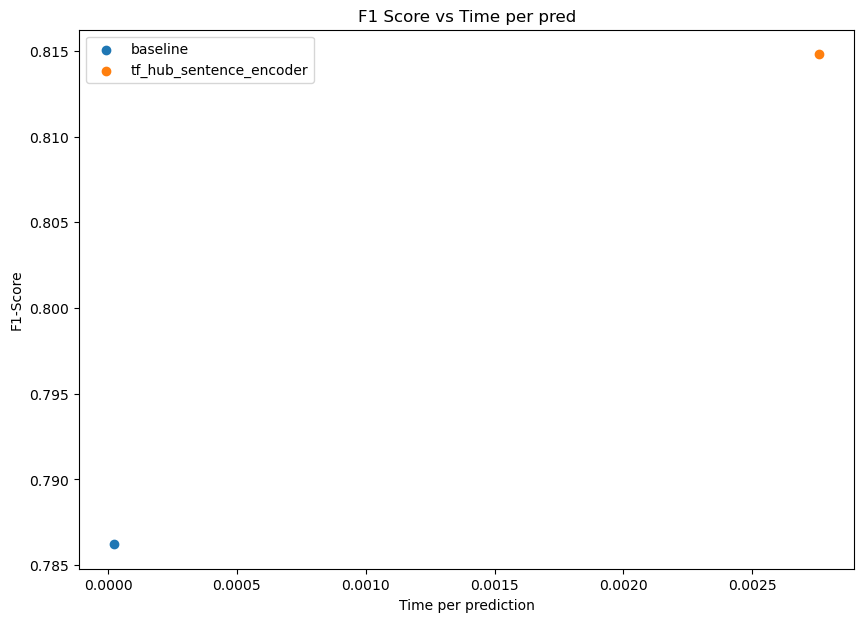

In [183]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(x=baseline_time_per_pred, y=baseline_results["f1"], label="baseline")
plt.scatter(x=model_6_time_per_pred, y=model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1 Score vs Time per pred")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score")